### Prep coho survival data for ecosystem model
 - Purpose: Prep survival data for model
 - By: G Oldford <br>
 - Date: 2019-2021 <br>
#### Data in:
   **1) Zimmerman et al 2015 / 2020 survival data**
         - MortSurvExploitReleaseNo.csv (extracted from master xlsx; edited manually to add functional group codes for EWE)
         - StocksList.csv (extracted from master xlsx; edited to add model functional group codes)
   **2) DFO Coho Survival data from CWT (via Josh Korman, Carl Walters)**
         - CohoMortality_Extracted.csv (includes interior coho data)
         
   **3) (omitted) Melynchuk survival data from CWT**
        - redundant data to (1)
        
#### Data out: 
   **1) EWE Time series file**
       - complete except the pool codes get set later using the time series titles and NA's are replaced later

Local paths: 
   - C:\Users\Greig\Sync\6. SSMSP Model\Model Greig\Data\1. Salmon\Survival Exploitation Rate\CohoSurvival_Zimmermanetal2015
   - C:\Users\Greig\Sync\6. SSMSP Model\Model Greig\Data\1. Salmon\Survival Exploitation Rate\CohoChin_Survival_CW
   - C:\Users\Greig\Sync\6. SSMSP Model\Model Greig\Data\1. Salmon\Survival Exploitation Rate\SalmonSurvExploit_Melynchuk_2017

In [1]:
# to install r packages
#install.packages("magick", repos='http://cran.us.r-project.org')
library(dplyr)
library(tidyverse)
library(plotly)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.4
v tibble  2.1.3     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.4.0
v readr   1.3.1     
Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'plotly' was built under R version 3.6.2"
Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

In [2]:
# #################################################
# (1) zimmerman coho mortality data
localpath_zimmerman = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//1. Salmon//Survival Exploitation Rate//CohoSurvival_Zimmermanetal2015//MODIFIED//"
mort_zimmerman <- read.csv(paste(localpath_zimmerman,"MortSurvExploitReleaseNo_Extracted.csv",sep=""))
mort_zimmerman$YEAR = mort_zimmerman$OEY
mort_zimmerman$MODELGROUP_CODE = mort_zimmerman$MODELGROUP_CODE_GO
mort_zimmerman$STOCK = mort_zimmerman$Watershed

# filter
mort_zimmerman <- mort_zimmerman %>% filter(MODELGROUP_CODE != "na") %>%
                                           select(MODELGROUP_CODE, YEAR, MORT, STOCKKEY_GO)
# add source_ID code
mort_zimmerman$SOURCE_ID = 5
mort_zimmerman$MORT = as.numeric(levels(mort_zimmerman$MORT))[mort_zimmerman$MORT]

#unique(mort_zimmerman$MODELGROUP_CODE_GO)

# #################################################
# (2) CW-JoshKorman-DFO Mortality Data (interior coho)
localpath_jk = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//1. Salmon//Survival Exploitation Rate//CohoChin_Survival_CW//MODIFIED//"
mort_jk = read.csv(paste(localpath_jk,"CohoMortality_Extracted.csv",sep=""))
mort_jk$YEAR = mort_jk$BROOD_YR
mort_jk$MORT = mort_jk$INST_MORTALITY
mort_jk$STOCK = mort_jk$JK.CW.DFO_CODE

# filter
mort_jk <- mort_jk %>% select(MODELGROUP_CODE, YEAR, MORT, SOURCE_ID, STOCKKEY_GO)

# #################################################
# (3) append / merge tables
mort_df = bind_rows(mort_zimmerman, mort_jk)
mort_df$EWE_TITLE = paste(paste(paste(mort_df$MODELGROUP_CODE, "M", sep="-"),mort_df$STOCKKEY_GO, sep="-"),mort_df$SOURCE_ID,sep="-")

# #################################################
# export to EWE time series file
# (1) pivot table and write to wide file
# (2) re-open file and insert header
temp_path = "C://temp//"

#Title	Combined_GST_FR_Escape_RelB_NuSEDS	Chin_Hatch_RelB_CW	Chin_1stYrM_1_CW	Chin_1stYrM_2_CW	Chin_C_Rel_CW
#Weight	1	1	1	1	1
#Pool Code	14	18	16	15	14
#Type	0	0	5	5	61
#1979	11.26655002	3.84	3.449022245	3.449022245	0.35
#1980	11.07767237	6.93	3.021428984	3.021428984	0.371
#1981	11.23108247	8.75	3.354206073	3.354206073	0.2533

# codes for 'type'
# relative biomass = 0 
# absolute biomass = 1
# biomass forcing = -1
# fishing mortality = 4
# relative fishing mortality = 104
# total mortality = 5
# constant total mortality = -5 (forcing?)
# catches = 6
# catches forcing = -6
# relative catches = 61
# average weight = 7

# (1) Pivot wide
mort_piv <- mort_df %>% select(EWE_TITLE, MORT, YEAR) %>%
pivot_wider(names_from = "EWE_TITLE", values_from = "MORT") %>%
arrange(YEAR) 

write.csv(mort_piv, paste(temp_path,"coho_M_temp.csv",sep=""),row.names=F)

# (2) insert EWE header

# insert (most) of the EWE custom header
# - pool code gets inserted later
x = readLines(paste(temp_path,"coho_M_temp.csv",sep=""))

# replace 'YEAR' with 'Title'
firstrow = do.call("rbind", strsplit(x[1:1], ","))
firstrow[1] = '"Title"'

secondrow = vector(mode="list", length=length(firstrow))
secondrow[1] = '"Weight"'
secondrow[-(1:1)] = 1

thirdrow = vector(mode="list", length=length(firstrow))
thirdrow[1] = '"Type"'
thirdrow[-(1:1)] = 5
x = c(paste(firstrow,collapse=","), paste(secondrow,collapse=","), paste(thirdrow,collapse=","), x[-(1:1)])

pathout = "C:\\Users\\Greig\\Sync\\6. SSMSP Model\\Model Greig\\Data\\1. Salmon\\Survival Exploitation Rate\\"
fileConn<-file(paste(pathout,"coho_M_EWE_TS.csv",sep=""))
writeLines(x, fileConn)
close(fileConn)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

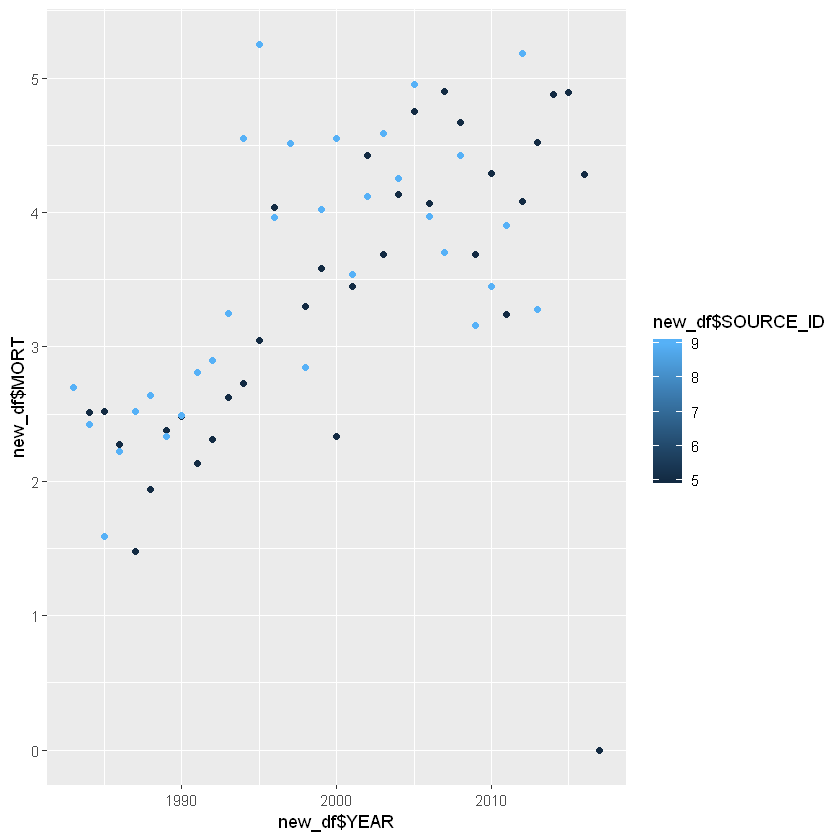

In [183]:
# quick compare of the mortality estimates from sources
new_df = filter(mort_df, STOCKKEY_GO=="INH")

library(ggplot2)
qplot(new_df$YEAR, new_df$MORT, color=new_df$SOURCE_ID)

In [3]:
mort_jk

MODELGROUP_CODE,YEAR,MORT,SOURCE_ID,STOCKKEY_GO
<fct>,<int>,<dbl>,<int>,<fct>
Coho-H-LFR-2,1983,2.70,9,INH
Coho-H-LFR-2,1984,2.42,9,INH
Coho-H-LFR-2,1985,1.59,9,INH
Coho-H-LFR-2,1986,2.22,9,INH
Coho-H-LFR-2,1987,2.52,9,INH
Coho-H-LFR-2,1988,2.64,9,INH
Coho-H-LFR-2,1989,2.33,9,INH
Coho-H-LFR-2,1990,2.49,9,INH
Coho-H-LFR-2,1991,2.81,9,INH


In [4]:
mort_zimmerman

MODELGROUP_CODE,YEAR,MORT,STOCKKEY_GO,SOURCE_ID
<fct>,<int>,<dbl>,<fct>,<dbl>
Coho-H-UGS-2,1973,1.95,BGQ,5
Coho-H-UGS-2,1974,0.72,BGQ,5
Coho-H-UGS-2,1975,1.16,BGQ,5
Coho-H-UGS-2,1976,1.56,BGQ,5
Coho-H-UGS-2,1977,1.81,BGQ,5
Coho-H-UGS-2,1978,1.39,BGQ,5
Coho-H-UGS-2,1979,1.35,BGQ,5
Coho-H-UGS-2,1980,1.92,BGQ,5
Coho-H-UGS-2,1981,2.09,BGQ,5


In [25]:
# OLD CODE
t2 <- t %>% pivot_longer(cols=starts_with("X"), names_to = "year", values_to = "survival") %>% 
#t2 <- t %>% pivot_longer(cols=-starts_with("OEY"), names_to = "year", values_to = "survival") %>% 
rename(Stock = "OEY") %>%
left_join(stocks, by = c("Stock" = "StockKey")) %>%
mutate(year = substring(year, 2, 5)) %>%
mutate(year = as.numeric(year))

Warning message:
"Column `Stock`/`StockKey` joining factors with different levels, coercing to character vector"

In [26]:
t2

Stock,year,survival,StockName,Location,OUTGROUP,lat,old_long,lon,ORIGIN,WILD
<chr>,<dbl>,<dbl>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<int>
BKH,1972,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1973,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1974,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1975,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1976,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1977,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1978,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1979,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0
BKH,1980,NA,Baker River (Skagit),PS,0,48.5394,121.7435,-121.7435,H,0


In [27]:
 write.csv(t2,'survival_joined_stocks.csv')